## PyMilvus dev

In [1]:
import sys
sys.path.append('/Users/luis/Desktop/ETH/Courses/SS25-DSL/src')

In [2]:
from semantic_search.utils import load_data
from importlib import reload

df, ref_df = load_data(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)
ref_df.rename(columns={'oaid': 'id', 'abstract': 'text'}, inplace=True)

/Users/luis/Desktop/ETH/Courses/SS25-DSL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
from semantic_search.store import faiss_store, models, milvus_store
from importlib import reload
reload(models)
reload(milvus_store)
reload(faiss_store)
from semantic_search.store.models import LocalEmbeddingModel, create_embedding_model
from semantic_search.store.milvus_store import MilvusDocumentStore
from semantic_search.store.faiss_store import FAISSDocumentStore

# ds = FAISSDocumentStore(
#     embedding_model=LocalEmbeddingModel(),
#     db_superdir='/Users/luis/Desktop/ETH/Courses/SS25-DSL/db',
#     store_name='test1',   
# )

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
ds = MilvusDocumentStore(
    embedding_model=create_embedding_model(model_name), 
    db_superdir='/Users/luis/Desktop/ETH/Courses/SS25-DSL/db',
    store_documents=True,
    store_raw_embeddings=True,
    store_name='MiniLM'
)

Using device: mps


In [26]:
# Show where Hugging Face caches models
import os
from huggingface_hub import scan_cache_dir

# Get the cache directory from environment variable or default location
cache_dir = os.environ.get("TRANSFORMERS_CACHE", 
                          os.environ.get("HF_HOME",
                                        os.path.join(os.path.expanduser("~"), ".cache", "huggingface")))

print(f"Hugging Face models are cached at: {cache_dir}")

# You can also see specific model cache locations
model_name = 'allenai/specter2'
model_cache = os.path.join(cache_dir, "models--" + model_name.replace("/", "--"))
print(f"\nSpecific model cache for {model_name}: {model_cache}")

# Check if the model is already cached
if os.path.exists(model_cache):
    print(f"Model {model_name} is already cached")
    print(f"Files in cache directory:")
    for root, dirs, files in os.walk(model_cache):
        for file in files:
            print(f"  - {os.path.join(root, file)}")
else:
    print(f"Model {model_name} is not yet cached")


Hugging Face models are cached at: /Users/luis/.cache/huggingface

Specific model cache for allenai/specter2: /Users/luis/.cache/huggingface/models--allenai--specter2
Model allenai/specter2 is not yet cached


In [29]:
from transformers import AutoTokenizer, AutoModel

model_name = 'allenai/specter2_base'
AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
# model.load_adapter("allenai/specter2", "proximity")


In [43]:
# if not ds.load_store(allow_fail=True):
ds.create_index_from_df(ref_df.rename(columns={'oaid': 'id', 'abstract': 'text'}), overwrite=True)

Dropped collection MiniLM


Chunking and encoding: 100%|██████████| 25041/25041 [00:26<00:00, 949.87it/s] 


Generating embeddings for 41045 chunks...


Generating embeddings: 100%|██████████| 5131/5131 [02:30<00:00, 34.17it/s]


Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting batch of 4000 chunks into Milvus...
Inserting final batch of 1045 chunks into Milvus...
Indexed 25041 documents in Milvus


In [44]:
ds._check_index_available()

True

In [45]:
ds.search('Attention is all you need', top_k=3, return_scores=True, return_doc_metadata=True, retrieval_method='hybrid')

[{'rank': 1,
  'id': 'W3104609094',
  'score': 0.5727618336677551,
  'doi': '10.18653/v1/2020.emnlp-main.112',
  'ref_via': 'openalex_id',
  'title': 'Generating Radiology Reports via Memory-driven Transformer',
  'text': 'Medical imaging is frequently used in clinical practice and trials for diagnosis and treatment. Writing imaging reports is time-consuming and can be error-prone for inexperienced radiologists. Therefore, automatically generating radiology reports is highly desired to lighten the workload of radiologists and accordingly promote clinical automation, which is an essential task to apply artificial intelligence to the medical domain. In this paper, we propose to generate radiology reports with memory-driven Transformer, where a relational memory is designed to record key information of the generation process and a memory-driven conditional layer normalization is applied to incorporating the memory into the decoder of Transformer. Experimental results on two prevailing rad

In [46]:
from semantic_search.data_retrieval.utils import extract_abstract_from_md
from semantic_search.utils import predict_refs_from_abstract
from semantic_search.benchmarking.utils import calc_metric_at_topk
from semantic_search.utils import load_data
from tqdm import tqdm
import pandas as pd

first_n_papers = 20
search_kwargs = {'retrieval_method': 'hybrid'}

df, ref_df = load_data(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)
# ref_df.rename(columns={'oaid': 'id', 'abstract': 'text'}, inplace=True)
df['fpath'] = df['fpath'].str.replace('/cluster/home/lcarretero/workspace/dsl/dsl-research-assistant', '/Users/luis/Desktop/ETH/Courses/SS25-DSL')
df['abstract'] = df['fpath'].apply(extract_abstract_from_md)
df = df[df.abstract.apply(len) > 0]
df = df.iloc[:first_n_papers]

available_refs = set(ref_df['oaid'].iloc[:1000].str.lower().values)
df['GT_refs'] = df.refs_oaids_from_dois.apply(lambda refs: [ref for ref in refs if ref in available_refs])
df['available_ref_ratio'] = df.GT_refs.apply(len) / df.refs_oaids_from_dois.apply(len)

max_n_refs = 200
ref_cnts = list(range(1, max_n_refs + 1))

results = []
for i, row in tqdm(df.iterrows(), total=len(df), desc='Predicting references'):
    pred = predict_refs_from_abstract(ds, row['abstract'], max_n_refs=max_n_refs, search_kwargs=search_kwargs)
    metrics = calc_metric_at_topk(row['GT_refs'], pred, ref_cnts)
    results.append(metrics)
results_df = pd.DataFrame(results)

Predicting references: 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


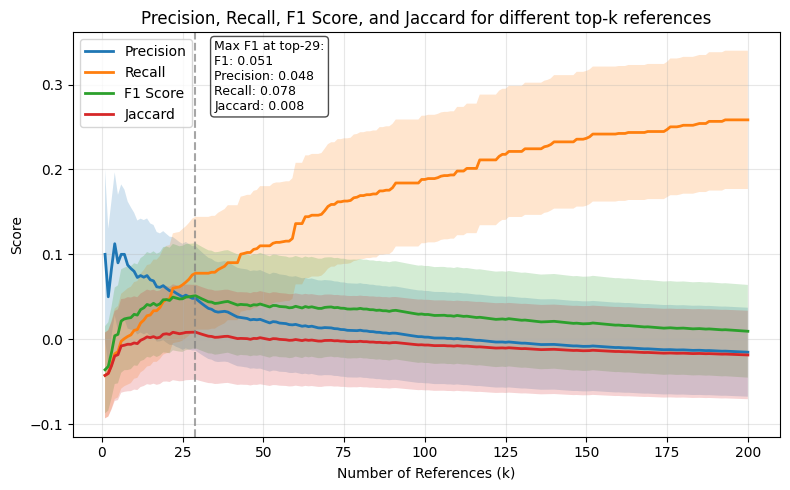

In [47]:
from matplotlib import pyplot as plt
import numpy as np

df = results_df

# Calculate mean metrics across all samples
metrics_mean = df.mean(axis=0)
metrics_err = df.std(axis=0) / np.sqrt(len(df))

# Extract metrics for different levels
ref_cnts = []
precision_values, recall_values, f1_values, jaccard_values = [], [], [], []
precision_err, recall_err, f1_err, jaccard_err = [], [], [], []

max_topk = max([int(name.split('top')[-1]) for name in metrics_mean.index.tolist() if name.startswith('prec_top')])
for topk in range(1, max_topk + 1):  # Assuming levels 1-200 based on output
    topk_str = f'top{topk}'
    if f'prec_{topk_str}' in metrics_mean:
        ref_cnts.append(topk)
        precision_values.append(metrics_mean[f'prec_{topk_str}'])
        recall_values.append(metrics_mean[f'rec_{topk_str}'])
        f1_values.append(metrics_mean[f'f1_{topk_str}'])
        precision_err.append(metrics_err[f'prec_{topk_str}'])
        recall_err.append(metrics_err[f'rec_{topk_str}'])
        f1_err.append(metrics_err[f'f1_{topk_str}'])
        jaccard_values.append(metrics_mean[f'jaccard_{topk_str}'])
        jaccard_err.append(metrics_err[f'jaccard_{topk_str}'])

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(ref_cnts, precision_values, label='Precision', marker='', linewidth=2)
plt.fill_between(ref_cnts, np.array(precision_values) - np.array(precision_err), 
                np.array(precision_values) + np.array(precision_err), alpha=0.2)
plt.plot(ref_cnts, recall_values, label='Recall', marker='', linewidth=2)
plt.fill_between(ref_cnts, np.array(recall_values) - np.array(recall_err), 
                np.array(recall_values) + np.array(recall_err), alpha=0.2)
plt.plot(ref_cnts, f1_values, label='F1 Score', marker='', linewidth=2)
plt.fill_between(ref_cnts, np.array(f1_values) - np.array(f1_err), 
                np.array(f1_values) + np.array(f1_err), alpha=0.2)
plt.plot(ref_cnts, jaccard_values, label='Jaccard', marker='', linewidth=2)
plt.fill_between(ref_cnts, np.array(jaccard_values) - np.array(jaccard_err), 
                np.array(jaccard_values) + np.array(jaccard_err), alpha=0.2)

# Find the index of maximum F1 score
max_f1_idx = np.argmax(f1_values)
max_f1_topk = ref_cnts[max_f1_idx]
max_f1 = f1_values[max_f1_idx]
max_precision = precision_values[max_f1_idx]
max_recall = recall_values[max_f1_idx]
max_jaccard = jaccard_values[max_f1_idx]

# Add vertical line at maximum F1 score
plt.axvline(x=max_f1_topk, color='gray', linestyle='--', alpha=0.7)

# Add text box with metrics at maximum F1
textstr = f'Max F1 at top-{max_f1_topk}:\nF1: {max_f1:.3f}\nPrecision: {max_precision:.3f}\nRecall: {max_recall:.3f}\nJaccard: {max_jaccard:.3f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.text(0.20, 0.80, textstr, transform=plt.gca().transAxes, fontsize=9,
            verticalalignment='bottom', bbox=props)

plt.xlabel('Number of References (k)')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 Score, and Jaccard for different top-k references')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Abstract size analysis

In [ ]:
texts = ref_df.rename(columns={'oaid': 'id', 'abstract': 'text'})['text'].tolist()

# Temporarily increase model_max_length to supress warning message.
tmp, ds.embedding_model.tokenizer.model_max_length = ds.embedding_model.tokenizer.model_max_length, sys.maxsize
texts_tokenized = ds.embedding_model.tokenizer(
    texts, 
    add_special_tokens=False, 
    return_token_type_ids=False, 
    return_attention_mask=False,
    padding=False,
)
ds.embedding_model.tokenizer.model_max_length = tmp

In [ ]:
import numpy as np
tkn_cnt = np.array([len(texts_tokenized[i]) for i in range(len(texts))])

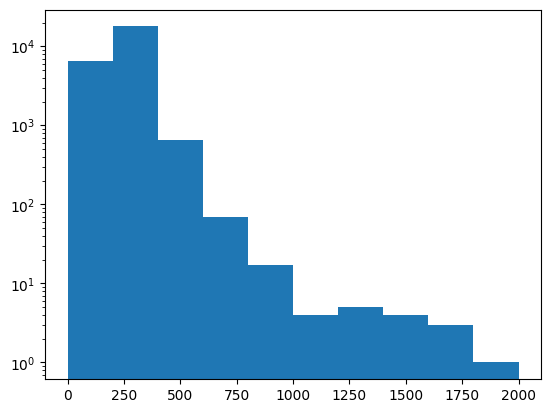

In [ ]:
from matplotlib import pyplot as plt
plt.hist(tkn_cnt, range=(0, 2000))
plt.yscale('log')

In [ ]:
(ref_df['text'].apply(len) > 4000).sum()

np.int64(20)

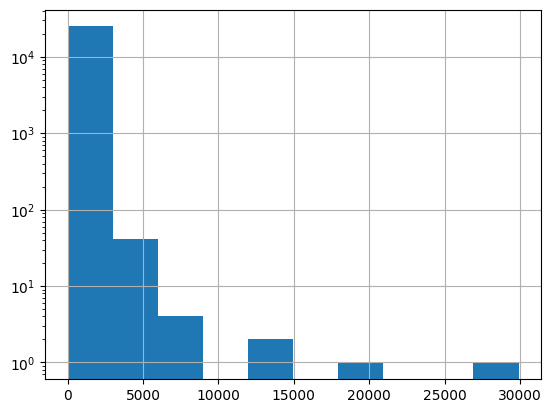

In [ ]:
ref_df['text'].apply(len).hist()
plt.yscale('log')